In [126]:
import numpy as np
import os
import re
import tensorflow as tf
import glob
from nilearn.masking import compute_epi_mask
from nibabel.testing import data_path
import nibabel as nib
import nilearn
import argparse
import os
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,
                          MaxPooling3D)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tqdm import tqdm
import scipy.io as sio
from nilearn.image import index_img
from nilearn import image
from nilearn import plotting
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker

In [2]:
print(os.getcwd())

/Users/vidhi/Desktop/Project


# Athena pipeline

In [ ]:
#getting a list of main folders of subjects 
class_1 = glob.glob('/Users/vidhi/desktop/KKI/*')

In [ ]:
s = []
for i in class_1:
    s.append(re.split('(\d+)',i))

In [ ]:
s1 = []
for i in range(len(s)):
    s1.append(s[i][1])
    

In [ ]:
all_files = []
for file in class_1:
    all_files.append(os.listdir(file))

In [ ]:
res = [x for j in range(len(all_files)) for x in all_files[j] if re.search('sfnwmrda', x)]

In [ ]:
res2 = [x for x in res if re.search('session_1_rest_1.nii.gz', x)]

In [ ]:
res3 = [x for x in res2 if re.search('sfnwmrda', x)]

In [ ]:
newlist = [x for x in res3 if not x.startswith('fc_')]

In [ ]:
#making a list of all path
subject_list = []
for subject in range(len(newlist)):
    s = class_1[subject] + '/' + newlist[subject]
    subject_list.append(s)

In [ ]:
#saving in new directory
for i in range(len(newlist)):
    img = nib.load(subject_list[i])
    nib.save(img , '/Users/vidhi/Desktop/vidhi/' + s1[i] +'.nii.gz')

In [111]:
#convert 4D image to 2D image and get slices 
Processed_data = glob.glob('/Users/vidhi/desktop/vidhi/*')

In [112]:
img_1 = nib.load(Processed_data[0])
img_1.shape

(49, 58, 47, 120)

In [113]:
#check if it has affine transformation or not
img_1.get_data_dtype() == np.dtype(np.int16)

False

In [114]:
first_rsn = image.index_img(img_1, 100)
print(first_rsn.shape)

(49, 58, 47)


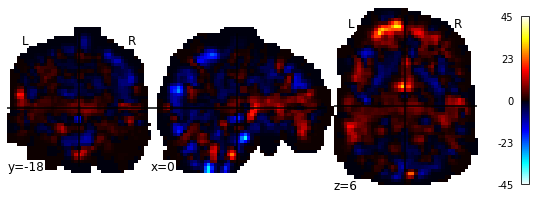

In [115]:
plotting.plot_stat_map(first_rsn)

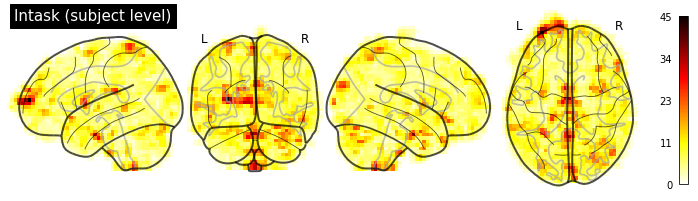

In [118]:
lass_img_sub10 = plotting.plot_glass_brain(first_rsn,
                          title='Intask (subject level)',
                          threshold = 1,
                          display_mode='lyrz',
                          plot_abs=True,
                          colorbar=True,
                          )

In [ ]:
mean_func1 = image.mean_img(img_1)

# Then we smooth, with a varying amount of smoothing, from none to 20mm
# by increments of 5mm
for smoothing in range(0, 25, 5):
    smoothed_img1 = image.smooth_img(mean_func1, smoothing)
    plotting.plot_epi(smoothed_img1,
                      title="Smoothing %imm" % smoothing)

In [ ]:
sx, sy, sz = first_rsn.header.get_zooms()
volume = sx * sy * sz 

In [ ]:
epi_Data = img_1.get_fdata()

In [ ]:
epi_Data.shape

# Getting labels

In [3]:
phenotypic = pd.read_csv('/Users/vidhi/Desktop/KKI_phenotypic.csv')

In [4]:
phenotypic

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Performance IQ,Full2 IQ,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2
0,1018959,3,0,12.36,1,0,NaN,2,44,47,...,115,NaN,103,1,1,NaN,NaN,NaN,1,NaN
1,1019436,3,1,12.98,1,3,NaN,2,71,60,...,108,NaN,122,1,1,NaN,NaN,NaN,1,NaN
2,1043241,3,1,9.12,1,0,NaN,2,40,40,...,106,NaN,120,1,1,NaN,NaN,NaN,1,NaN
3,1266183,3,0,9.67,1,0,NaN,2,47,44,...,96,NaN,120,1,1,NaN,NaN,NaN,1,NaN
4,1535233,3,1,9.64,0,0,NaN,2,42,41,...,135,NaN,122,1,1,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,8337695,3,1,8.80,1,1,ODD,2,71,74,...,112,NaN,94,2,1,NaN,NaN,NaN,1,NaN
79,8432725,3,0,11.51,1,0,Simple Phobia,2,-999,-999,...,102,NaN,116,1,1,NaN,NaN,NaN,1,NaN
80,8628223,3,0,10.81,1,0,Simple phobia,2,42,49,...,86,NaN,97,1,1,NaN,NaN,NaN,1,NaN
81,8658218,3,1,9.75,1,0,Simple Phobia,2,56,55,...,115,NaN,114,1,0,NaN,NaN,NaN,1,NaN


In [5]:
labels = phenotypic['DX']

In [6]:
labels = pd.DataFrame(labels)

In [7]:
ID = phenotypic['ScanDir ID']
ID = pd.DataFrame(ID)

In [8]:
result = pd.concat([ID,labels], axis=1, join='inner')

# NIAK pipeline


In [ ]:
pip install mat4py

In [9]:
#getting fmri image path of one website
nifti_files = glob.glob('/Users/vidhi/desktop/fmri_KKI/*')

In [10]:
nifti_files[0]

'/Users/vidhi/desktop/fmri_KKI/fmri_X_1962503_session_1_run1.nii.gz'

In [11]:
#separating Id from the list of path 
s_nifti = []
for i in nifti_files:
    s_nifti.append(re.split('(\d+)',i))

In [12]:
#separting ID from the list of path 
s1_nifti = []
for i in range(len(s_nifti)):
    s1_nifti.append(s_nifti[i][1])

In [13]:
#ID
len(s1_nifti)

82

In [14]:
#getting time-series data
time_series = glob.glob('/Users/vidhi/desktop/rois/*')

In [17]:
time_series_list = []

for i in range(len(time_series)):
    #print(s1_nifti[i])
    test = sio.loadmat('/Users/vidhi/desktop/rois/tseries_rois_X_'+s1_nifti[i]+'_run1.mat')
    time_series_list.append(test.get('tseries'))
    

In [18]:
time_series_list[0].shape

(124, 954)

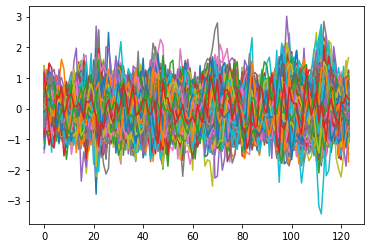

In [19]:
import matplotlib.pyplot as plt
plt.plot(time_series_list[0])
plt.show()

In [20]:
#loading one subject of FMRI file
Img_1 = nib.load(nifti_files[0])
Img_1.shape

(53, 64, 46, 124)

In [21]:
#converting images into numpy array
arr = []
for i in range(len(nifti_files)):
    Img = nib.load(nifti_files[i])
    x = Img.get_data()
    arr.append(x)    

/Users/vidhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


In [22]:
Niak_1 = image.index_img(Img_1, 1)
print(Niak_1.shape)

(53, 64, 46)


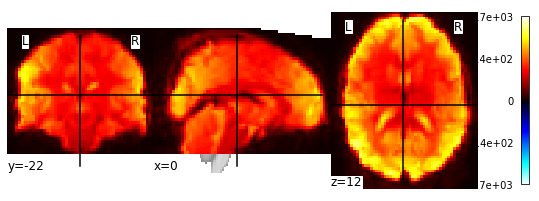

In [23]:
plotting.plot_stat_map(Niak_1)

In [24]:
Niak_info = Niak_1.header

In [25]:
print(Niak_info)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 53 64 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1685.76
cal_min         : -4.175456
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'mnc2nii /media/Backup/database/cbrainDP/kki_output//fmri/fmri_X_1962503_session'
aux_file        : b''
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       

/Users/vidhi/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:602: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


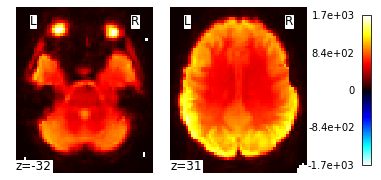

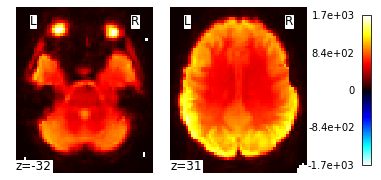

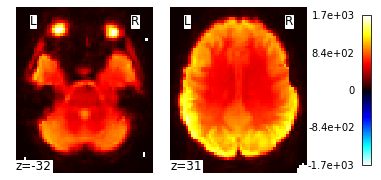

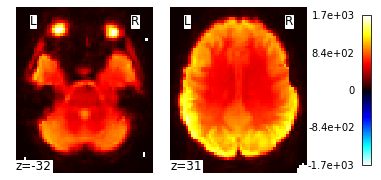

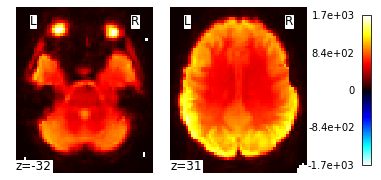

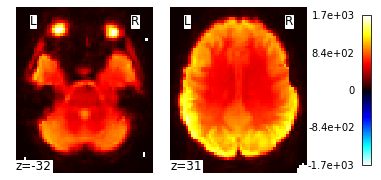

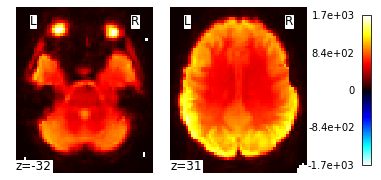

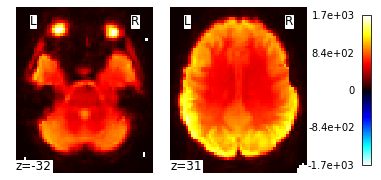

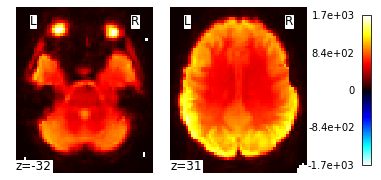

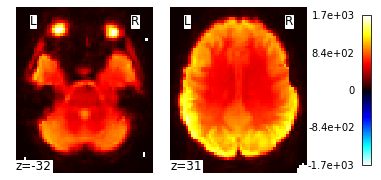

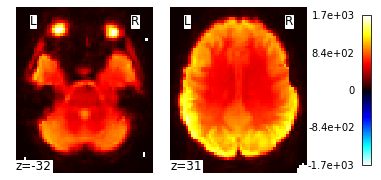

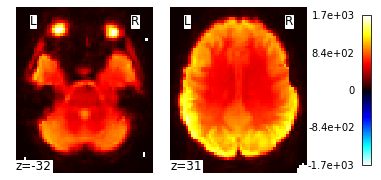

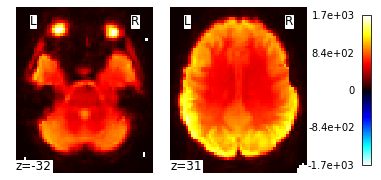

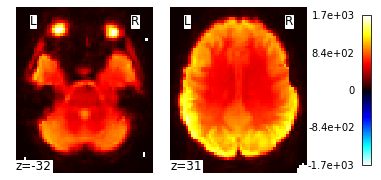

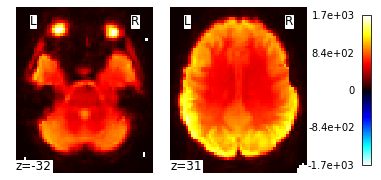

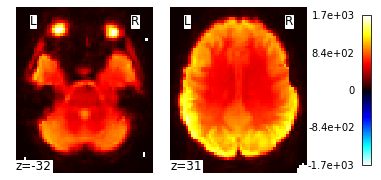

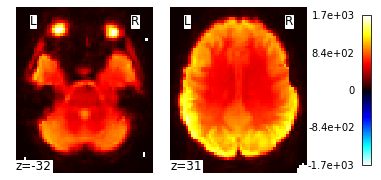

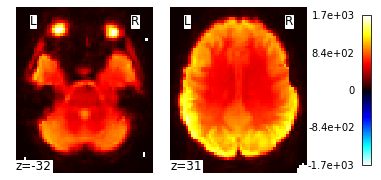

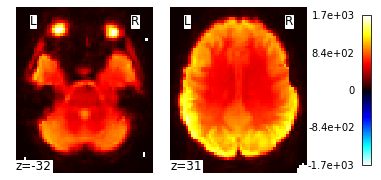

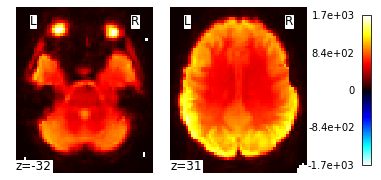

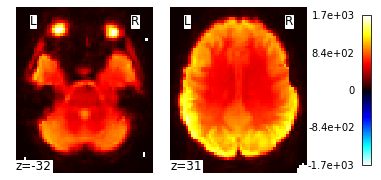

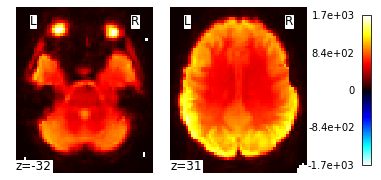

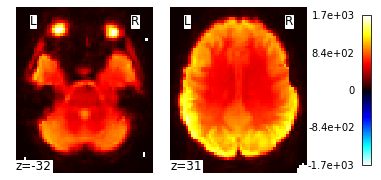

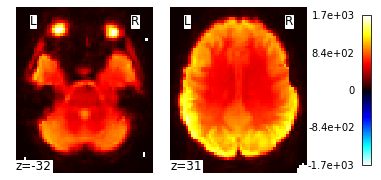

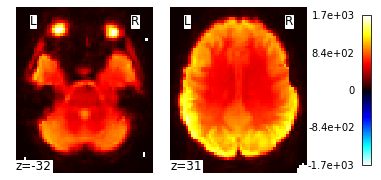

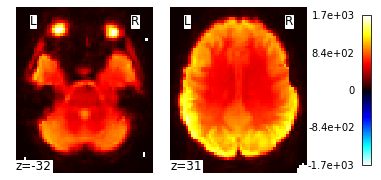

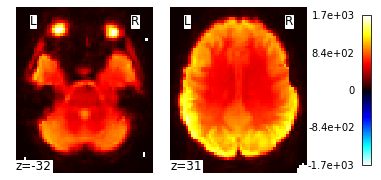

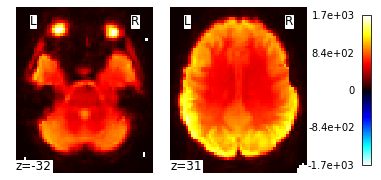

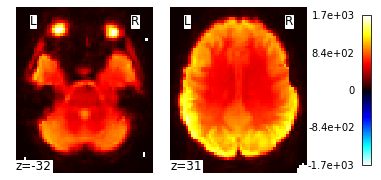

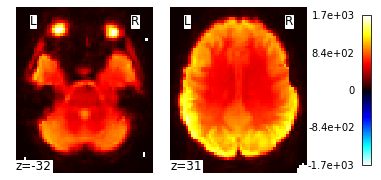

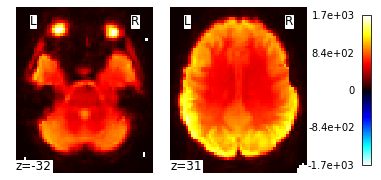

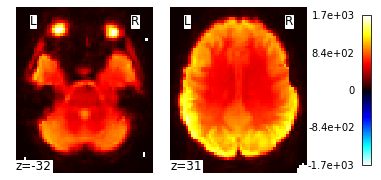

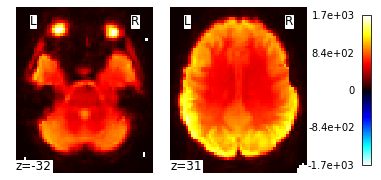

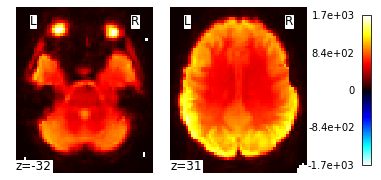

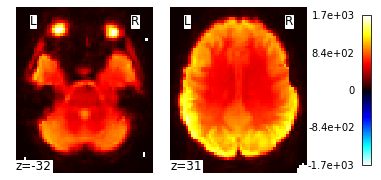

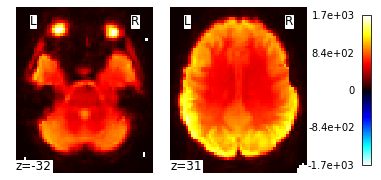

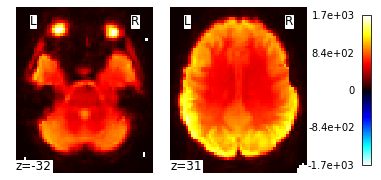

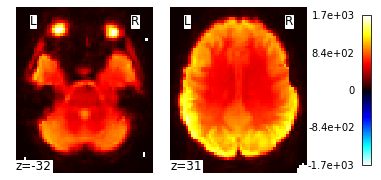

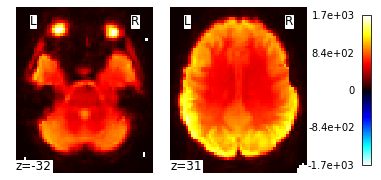

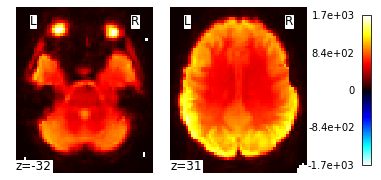

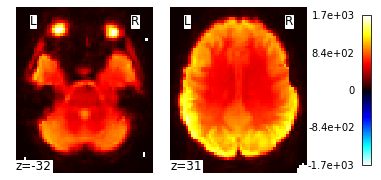

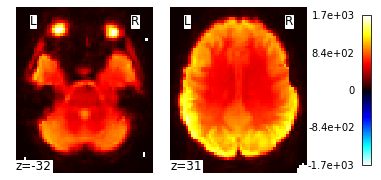

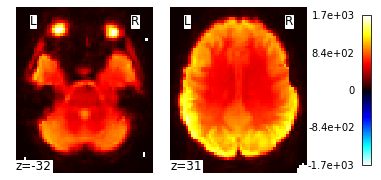

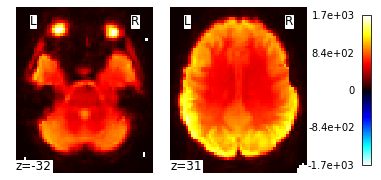

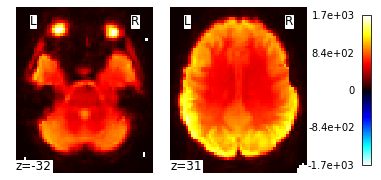

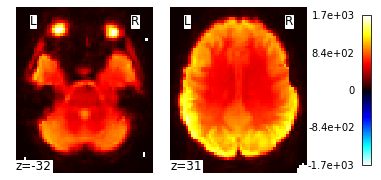

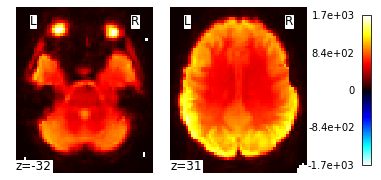

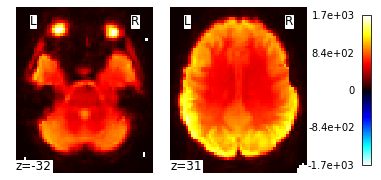

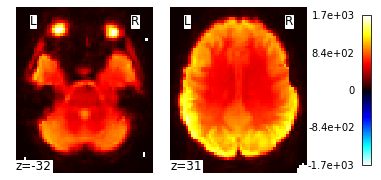

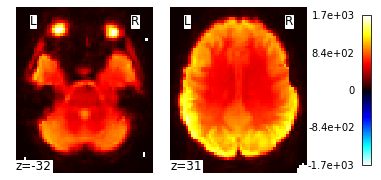

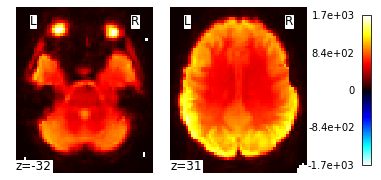

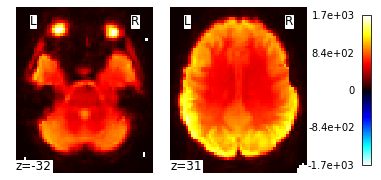

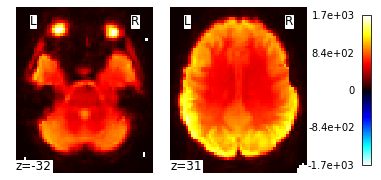

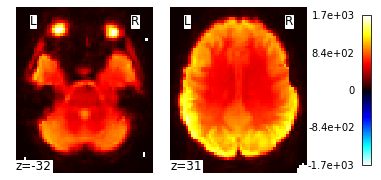

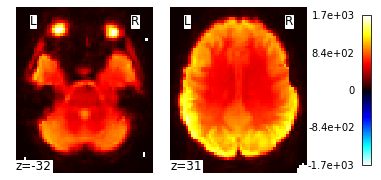

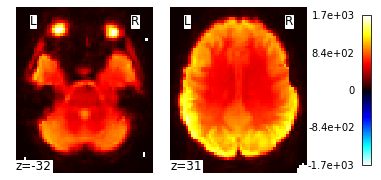

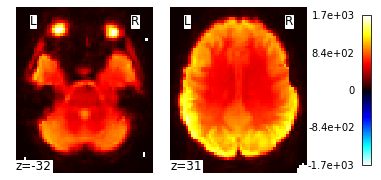

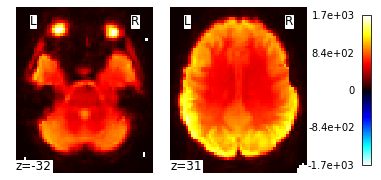

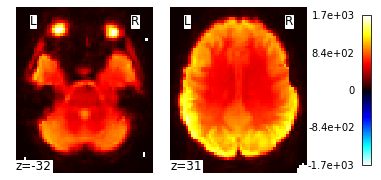

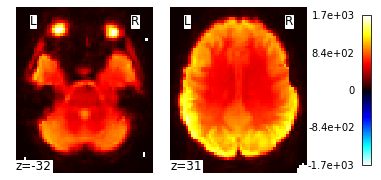

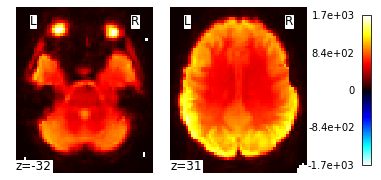

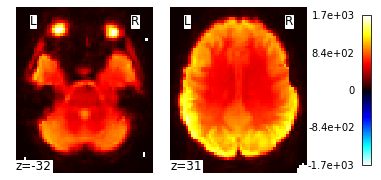

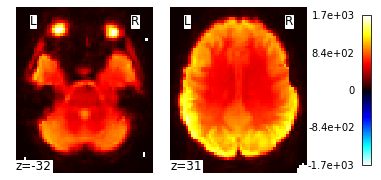

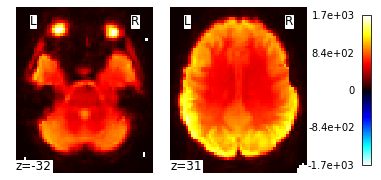

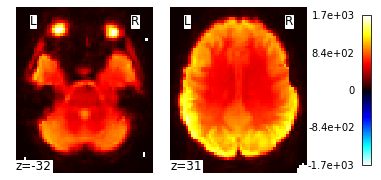

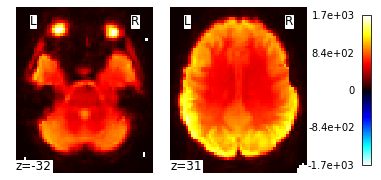

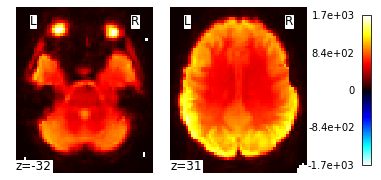

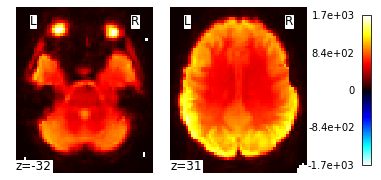

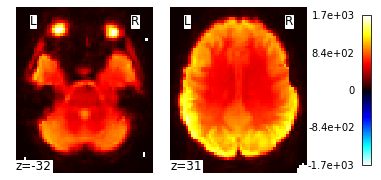

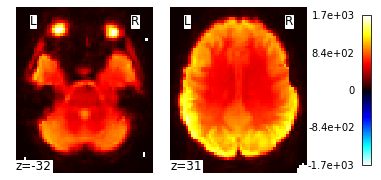

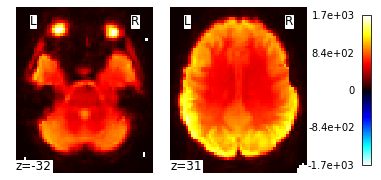

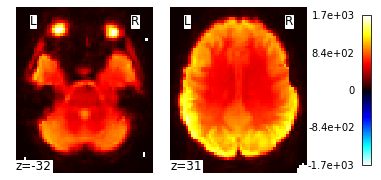

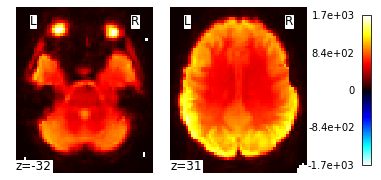

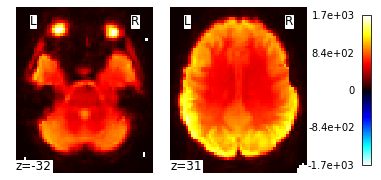

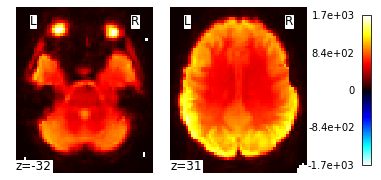

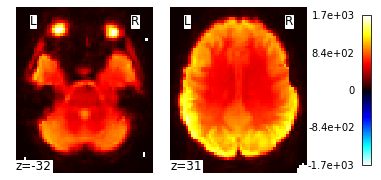

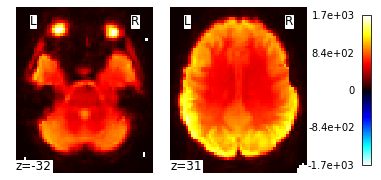

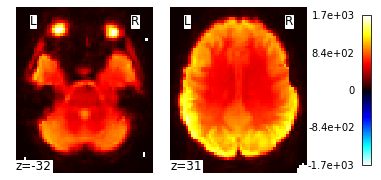

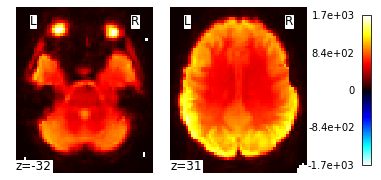

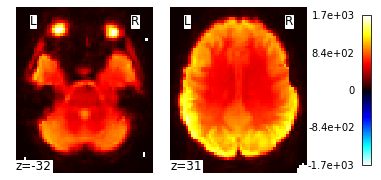

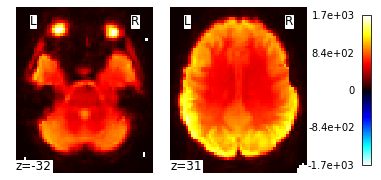

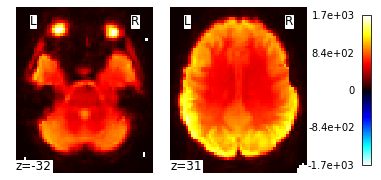

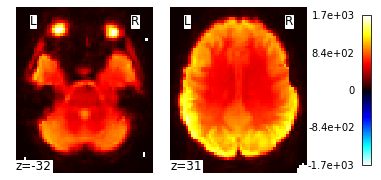

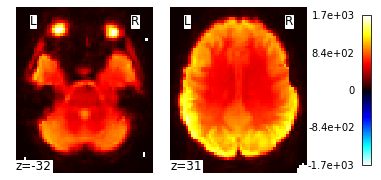

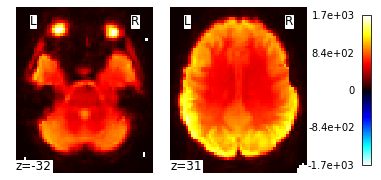

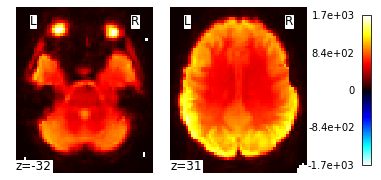

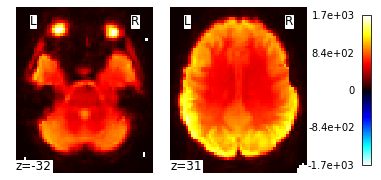

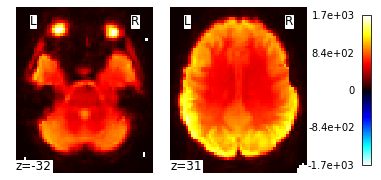

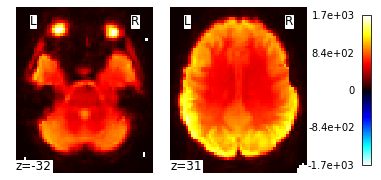

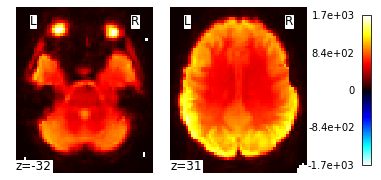

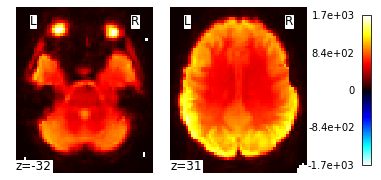

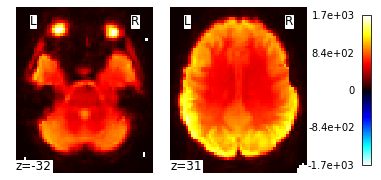

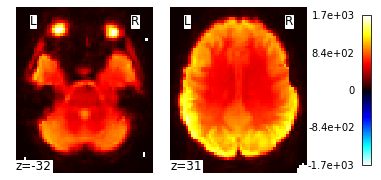

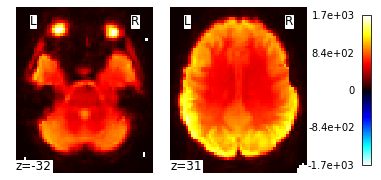

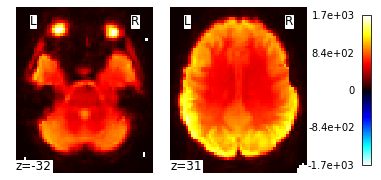

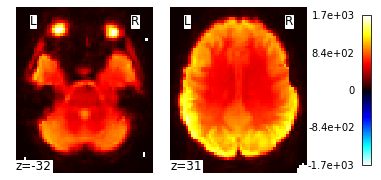

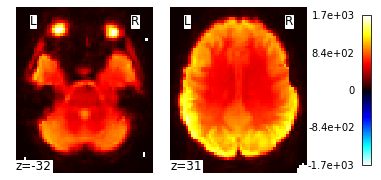

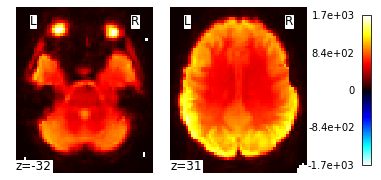

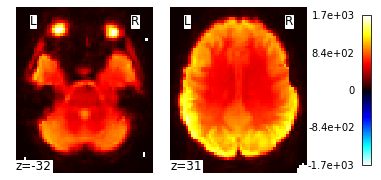

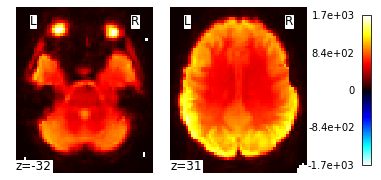

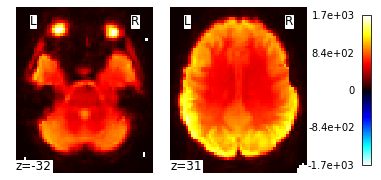

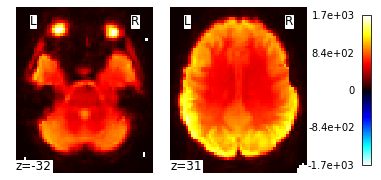

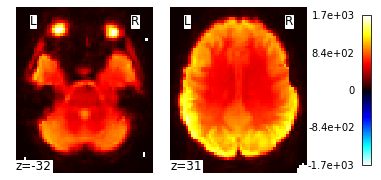

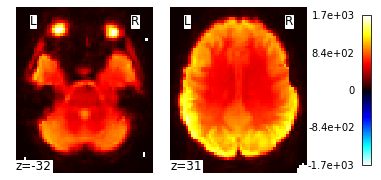

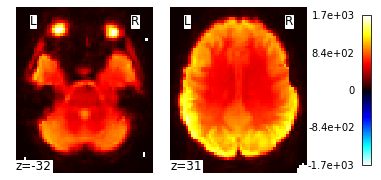

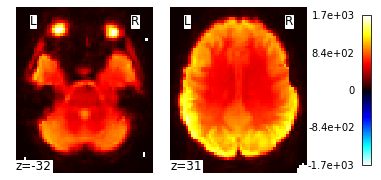

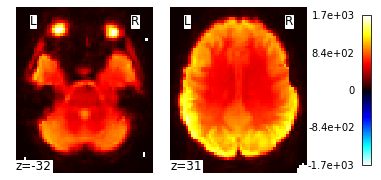

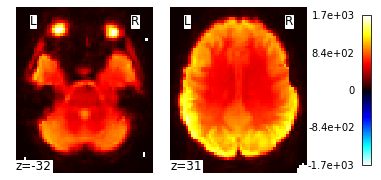

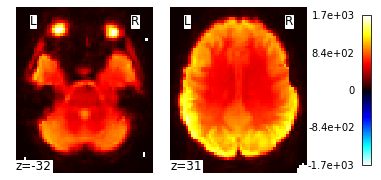

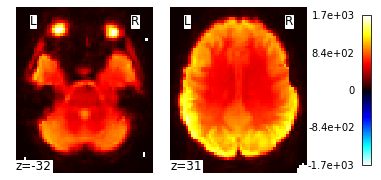

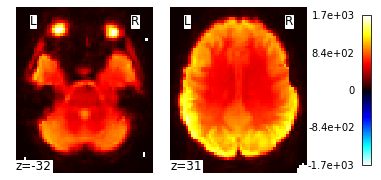

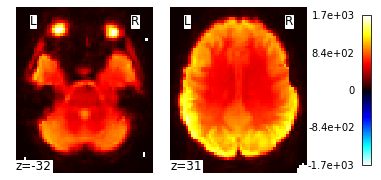

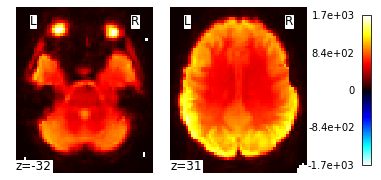

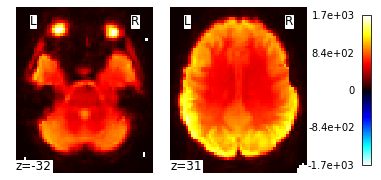

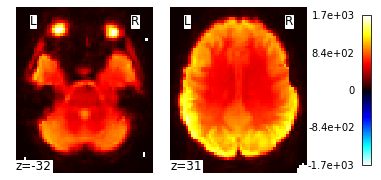

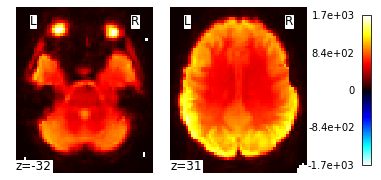

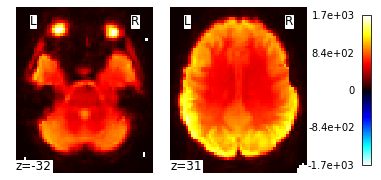

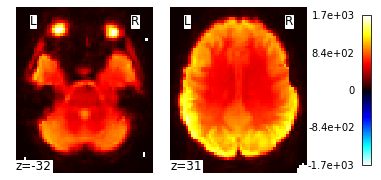

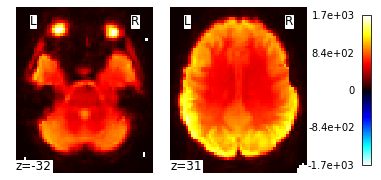

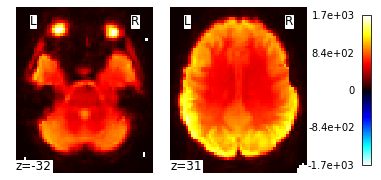

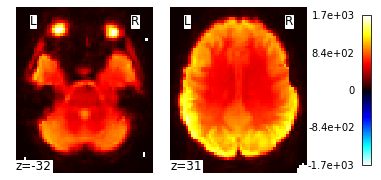

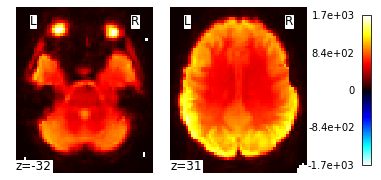

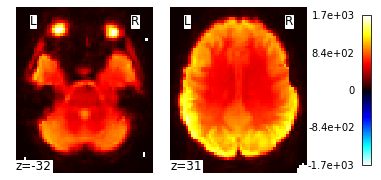

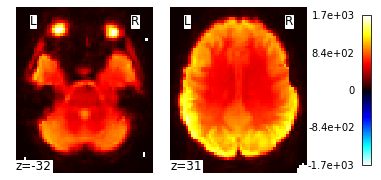

In [26]:
for img in image.iter_img(Img_1):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(Niak_1, threshold=3, display_mode="z", cut_coords=2,
                           colorbar=True)

In [34]:
#sorting labels according to file

Id = result['ScanDir ID'].values.tolist()
label = result['DX'].values.tolist()
#df2 = s1_nifti[0].values.tolist() 

df_sort = []
for i in range(len(s1_nifti)):
    df_sort.append(int(s1_nifti[i]))

In [52]:
s1_nifti[0]

'1962503'

In [36]:
#sorting the labels according to file

new_list = []
for i in range(len(df_sort)):
    if df_sort[i] in Id:
        s = Id.index(df_sort[i])
        #print(df_sort[i])
        new_list.append(label[s])
        #print(label[s])

/Users/vidhi/opt/anaconda3/lib/python3.7/site-packages/nilearn/image/image.py:214: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  .format(fwhm))


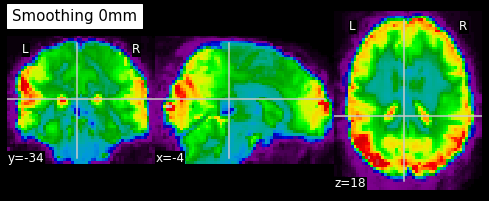

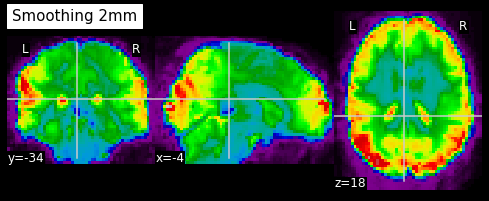

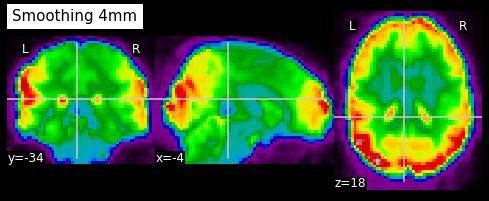

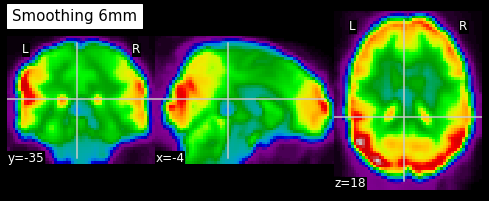

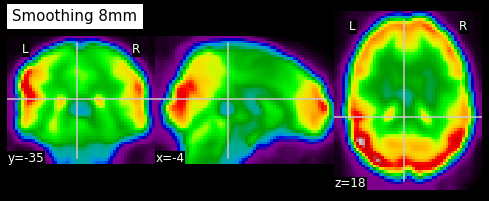

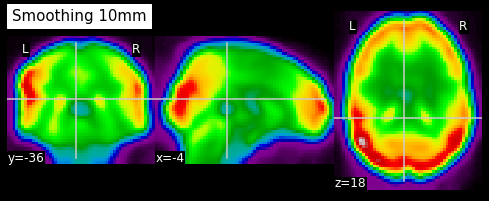

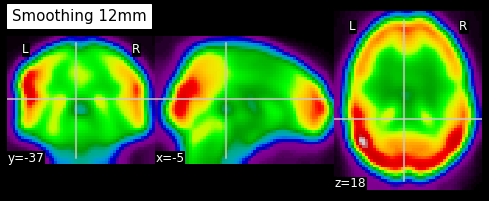

In [39]:
#Preprocessing Visualization of one instance

data = arr 
mean_func = image.mean_img(nifti_files[0])

#smoothing  with a varying amount of smoothing, from none to 14mm by increment of 2mm
for smoothing in range(0, 14, 2):
    smoothed_img = image.smooth_img(mean_func, smoothing)
    plotting.plot_epi(smoothed_img,title="Smoothing %imm" % smoothing)

In [40]:
#smoothing volume
#mean_func = image.mean_img(nifti_files[1])
smoothed_img = image.smooth_img(nifti_files[1], 2)


In [122]:
#cleaning the image by removing mean and linear detrending of one instance
s = image.clean_img(smoothed_img, sessions=None, detrend=True,
                    standardize=True, confounds=None, low_pass=None,
                    high_pass=None, t_r=None, ensure_finite=False, mask_img=None)

In [123]:
s1 = image.index_img(s, 100)

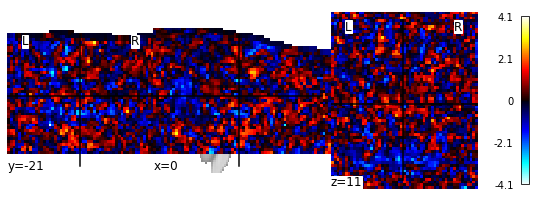

In [124]:
#visualizing the cleaned image
plotting.plot_stat_map(s1)

In [ ]:
#Performing smoothing and cleaning of image on whole dataset and saving it to another folder
for i in range(len(nifti_files)):
    smoothed_img = image.smooth_img(nifti_files[i], 2)
    s = image.clean_img(smoothed_img, sessions=None, detrend=True,
                    standardize=True, confounds=None, low_pass=None,
                    high_pass=None, t_r=None, ensure_finite=False, mask_img=None)
    nib.save(s , '/Users/vidhi/Desktop/Niak_preprocessed/' + s1_nifti[0][i] +'.nii.gz')

In [53]:
processed_data = nib.load('/Users/vidhi/Desktop/Niak_preprocessed/' + s1_nifti[1] +'.nii.gz')

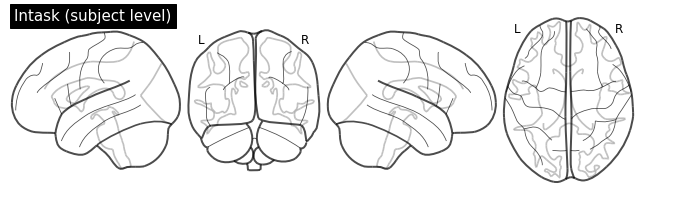

In [110]:
lass_img_sub10 = plotting.plot_glass_brain(mask_img,
                          title='Intask (subject level)',
                          threshold = 5,
                          display_mode='lyrz',
                          plot_abs=True,
                          colorbar=True,
                          )

In [54]:
#brain mask for transforming 4D to 2D
mask_img = compute_epi_mask(nifti_files[0])

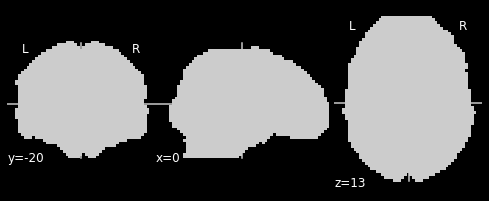

In [55]:
plotting.plot_epi(mask_img)

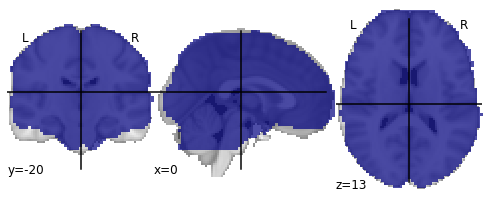

In [56]:
from nilearn.plotting import plot_roi
plot_roi(mask_img)

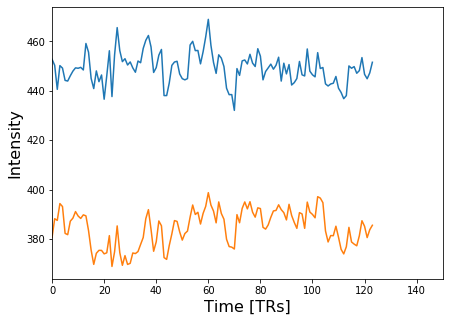

In [57]:
#convering 4D to 2D (voxel x timeseries) and plotting graph
from nilearn.masking import apply_mask
masked_data = apply_mask(nifti_files[0], mask_img)

# masked_data shape is (timepoints, voxels) plot the first 150 timepoints from two voxels

# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:150, :2])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.show()




In [58]:
#shape after 4D to 2D transformation
masked_data.shape

(124, 64610)

In [60]:
#reshaping the dimensions of the data before passing to 3D cnn
Dataset = []
for i in range(82):
    Img = nib.load('/Users/vidhi/Desktop/Niak_preprocessed/' + s1_nifti[i] +'.nii.gz')
    x = Img.get_data()
    result = x[:, :, :,:1]
    Dataset.append(result)

/Users/vidhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


In [61]:
Dataset[0].shape

(53, 64, 46, 1)

In [62]:
#Binary classification
for i in range(len(new_list)):
    if new_list[i] > 1:
        new_list[i] = 1
    else:
        continue 
X = np.array(Dataset)
Y = np.array(new_list)

In [63]:
#splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(X,Y , test_size=0.2, random_state=42)

In [64]:
x_train.shape

(65, 53, 64, 46, 1)

In [101]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [102]:
def batch_generator(X, y, batch_size=10, 
                    shuffle=False, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])        

In [103]:
class Conv3dNN(object):
    def __init__(self, n_classes=2, batchsize=10,
                 epochs=10, learning_rate=1e-4, 
                 dropout_rate=0.5,
                 shuffle=False):
        #np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        self.n_classes = n_classes
                
        g = tf.Graph()
        with g.as_default():
            ## set random-seed:
            #tf.set_random_seed(random_seed)
            
            ## build the network:
            self.build()

            ## initializer
            self.init_op = \
                tf.global_variables_initializer()

            ## saver
            self.saver = tf.train.Saver()
            
        ## create a session
        self.sess = tf.Session(graph=g)
                
    def build(self):
        
        # Placeholders for X and y:
        tf_x = tf.placeholder(tf.float32, 
                              shape=[None, 53, 64, 46,1],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[None],
                              name='tf_y')
        is_train = tf.placeholder(tf.bool, 
                              shape=(),
                              name='is_train')
        
        ## reshape x to 5D tensor:
        ## [batchsize, x, y, z, 1]
        tf_x_vol = tf.reshape(tf_x, shape=[-1, 53, 64, 46, 1],
                             name='input_x_3d_volumes')

        ## One-hot encoding:
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=2,
                              dtype=tf.float32,
                              name='input_y_onehot')

        ## 1st layer: Conv_1
        h1 = tf.layers.conv3d(tf_x_vol, 
                              filters=16, 
                              kernel_size=(3, 3, 3), 
                              strides=(1, 1, 1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling
        h1_pool = tf.layers.max_pooling3d(h1, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        
        ## 2nd layer: Conv_2
        h2 = tf.layers.conv3d(h1_pool, 
                              filters=16, 
                              kernel_size=(3, 3, 3), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h2_pool = tf.layers.max_pooling3d(h2, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))

        ## 3rd layer: Conv_3
        h3 = tf.layers.conv3d(h2_pool, 
                              filters=16, 
                              kernel_size=(3, 3, 3), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h3_pool = tf.layers.max_pooling3d(h3, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        #Conv_4
        h4 = tf.layers.conv3d(h3_pool, 
                              filters=16, 
                              kernel_size=(3, 3, 3), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h4_pool = tf.layers.max_pooling3d(h4, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        
         #Conv_
        h4 = tf.layers.conv3d(h3_pool, 
                              filters=16, 
                              kernel_size=(3, 3, 3), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h4_pool = tf.layers.max_pooling3d(h4, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        
        
        ## 4th layer: Fully Connected
        input_shape = h3_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h3_pool_flat = tf.reshape(h3_pool, 
                              shape=[-1, n_input_units])
        
        h4 = tf.layers.dense(h3_pool_flat, 128, 
                              activation=tf.nn.relu)

        ## Dropout
        h4_drop = tf.layers.dropout(h4, 
                              rate=self.dropout_rate,
                              training=is_train)
        
        ## 5th layer: Fully Connected (linear activation)
        h5 = tf.layers.dense(h4_drop, self.n_classes, 
                              activation=tf.nn.sigmoid)

        ## Prediction
        predictions = {
            'probabilities': tf.nn.softmax(h5, 
                              name='probabilities'),
            'labels': tf.cast(tf.argmax(h5, axis=1), 
                              tf.int32, name='labels')}
        
        ## Loss Function and Optimization
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=h5, labels=tf_y_onehot),
            name='cross_entropy_loss')
        
        ## Optimizer:
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss,
                              name='train_op')

        ## Finding accuracy
        correct_predictions = tf.equal(
            predictions['labels'], 
            tf_y, name='correct_preds')
        
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')
        
    def train(self, training_set, 
              validation_set=None,
              initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)

        self.train_cost_ = []
        X_data_tr = np.array(training_set[0])
        y_data_tr = np.array(training_set[1])

        for epoch in range(1, self.epochs + 1):
            batch_gen_tr = \
                batch_generator(X_data_tr, y_data_tr, batch_size=self.batchsize, 
                                 shuffle=self.shuffle)
            avg_loss = 0.0
            for i, (batch_x,batch_y) in \
                enumerate(batch_gen_tr):
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': True} ## for dropout
                loss, _ = self.sess.run(
                        ['cross_entropy_loss:0', 'train_op'], 
                        feed_dict=feed)
                avg_loss += loss
                
            print('Epoch %02d: Training Avg. Loss: '
                  '%7.3f' % (epoch, avg_loss), end=' ')
            if validation_set is not None:
                
                X_data_ts = np.array(training_set[0])
                y_data_ts = np.array(training_set[1])
                # test accuracy
                batch_gen_ts = \
                batch_generator(X_data_ts, y_data_ts,
                                 shuffle=False,batch_size=self.batchsize)
                avg_valid_acc = 0.0
                for i, (batch_x,batch_y) in \
                    enumerate(batch_gen_ts):
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'is_train:0': False} ## for dropout
                    avg_valid_acc = avg_valid_acc + self.sess.run('accuracy:0', feed_dict=feed)
                avg_valid_acc = avg_valid_acc/(i+1)
                
                print('Validation Acc: %7.3f' % avg_valid_acc)
            else:
                print()
                    
    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test,
                'is_train:0': False} ## for dropout
        if return_proba:
            return self.sess.run('probabilities:0',
                                 feed_dict=feed)
        else:
            return self.sess.run('labels:0',
                                 feed_dict=feed)